In [1]:
import gym
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
import time

In [106]:
class Policy(nn.Module):
    def __init__(self, n_actions):
        super(Policy, self).__init__()
        
        self.temp = 0
        
        self.n_actions = n_actions
        
        self.layers = nn.Sequential(
            nn.Linear(6, 16), nn.ReLU(),
            nn.Linear(16, 8), nn.ReLU(),
            nn.Linear(8, n_actions),
        )

    def forward(self, d_obs, deterministic=False):
        logits = self.layers(d_obs)
        if deterministic:
            action = torch.argmax(logits[0])
            action_prob = 1.0
        else:
            c = torch.distributions.Categorical(logits=logits)
            action = c.sample()
            action_prob = c.probs[0, action]
        return action, action_prob, logits

    def state_to_tensor(self, I, opponent=False):
        """ prepro 210x160x3 uint8 frame into 6000 (75x80) 1D float vector """
        I = I[34:194] # crop height
        I = I[::2,::2,0] # downsample by factor of 2.
        I[I == 144] = 0 # erase background (background type 1)
        I[I == 109] = 0 # erase background (background type 2)
        I[I != 0] = 1 # everything else 
        return I
        #return torch.from_numpy(I.astype(np.float32).ravel()).unsqueeze(0)

    
    def get_opponent_col(self, obs):
        #return obs.cpu().numpy().reshape(75, 80)[:, 8:10]
        return obs[:, 8:10]

    def get_player_col(self, obs):
        #return obs.cpu().numpy().reshape(75, 80)[:, 70:72]
        return obs[:, 70:72]
    
    def get_paddle(self, col, player = True):
        '''Takes a processed image and finds the center of paddle
        '''
        if player:
            look = np.where(self.get_player_col(col) == 1.)
        else:
            look = np.where(self.get_opponent_col(col) == 1.)
        if len(look) == 0:
            return -1
        if len(look[0]) == 0:
            return -1
        return look[0][0] + 3.5 # The paddle is 8 long, 3.5 is the middle
    
    def remove_paddles(self, obs):
        obs = np.array(obs)
        obs[:, 8:10] = 0.0
        obs[:, 70:72] = 0.0
        return obs

    def get_ball(self, obs):
        obs = self.remove_paddles(obs)
        self.temp = obs
        locs = np.where(obs == 1.)
        if len(locs) == 0:
            return 0., 0.
        if len(locs[0]) == 0:
            ball_y = 0.
        elif len(locs[0]) > 1:
            ball_y = locs[0][0]
        elif len(locs[0]) == 1:
            ball_y = locs[0]
        else:
            ball_y = locs[0]
        if len(locs) == 2:
            if len(locs[1]) == 0:
                ball_x = 0.
            elif len(locs[1]) > 1:
                ball_x = locs[1][0]
            else:
                ball_x = locs[1]
        else:
            ball_x = 0.
            
        return ball_y, ball_x
    
    def get_velocity(self, obs, prev_obs):
        t0y, t0x = self.get_ball(prev_obs)
        t1y, t1x = self.get_ball(obs)
        vy = t1y-t0y
        vx = t1x-t0x
        return vy, vx 
       
    def generate_features(self, obs, prev_obs):
        obs = self.state_to_tensor(obs)
        plt.imshow(obs)
        prev_obs = self.state_to_tensor(prev_obs)
        player_loc = self.get_paddle(obs)
        opponent_loc = self.get_paddle(obs, player = False)
        ball_y, ball_x = self.get_ball(obs)
        #Normalize features:
        player_loc /= 80.
        opponent_loc /= 80.
        v_y, v_x = self.get_velocity(obs, prev_obs)
        print(ball_y, ball_x)
        ball_y /= 80.
        ball_x /= 80.
        return [player_loc, opponent_loc, ball_y, ball_x, v_y, v_x]
    
    
    def convert_action(self, action):
        if self.n_actions == 2:
            return action + 2
        elif self.n_actions == 3:
            return actions + 1
        else:
            #Raise an error
            pass


In [107]:
policy = Policy(n_actions = 2)

In [108]:
env.close()

In [109]:
env = gym.make('PongNoFrameskip-v4')
prev_obs = env.reset()

0.0 0.0
Player loc: 0.43125
Opponent_loc: -0.0125
Ball y: 0.0
Ball x: 0.0
Velocity y: -6.0
Velocity x: -1.0
0.0 0.0
Player loc: 0.40625
Opponent_loc: -0.0125
Ball y: 0.0
Ball x: 0.0
Velocity y: 0.0
Velocity x: 0.0
0.0 0.0
Player loc: 0.40625
Opponent_loc: -0.0125
Ball y: 0.0
Ball x: 0.0
Velocity y: 0.0
Velocity x: 0.0
0.0 0.0
Player loc: 0.40625
Opponent_loc: -0.0125
Ball y: 0.0
Ball x: 0.0
Velocity y: 0.0
Velocity x: 0.0
0.0 0.0
Player loc: 0.40625
Opponent_loc: -0.0125
Ball y: 0.0
Ball x: 0.0
Velocity y: 0.0
Velocity x: 0.0
0.0 0.0
Player loc: 0.39375
Opponent_loc: -0.0125
Ball y: 0.0
Ball x: 0.0
Velocity y: 0.0
Velocity x: 0.0
0.0 0.0
Player loc: 0.39375
Opponent_loc: -0.0125
Ball y: 0.0
Ball x: 0.0
Velocity y: 0.0
Velocity x: 0.0
0.0 0.0
Player loc: 0.35625
Opponent_loc: -0.0125
Ball y: 0.0
Ball x: 0.0
Velocity y: 0.0
Velocity x: 0.0
0.0 0.0
Player loc: 0.35625
Opponent_loc: -0.0125
Ball y: 0.0
Ball x: 0.0
Velocity y: 0.0
Velocity x: 0.0
0.0 0.0
Player loc: 0.34375
Opponent_loc: -0

58 22
Player loc: 0.04375
Opponent_loc: 0.76875
Ball y: 0.725
Ball x: 0.275
Velocity y: 1
Velocity x: -1
58 22
Player loc: 0.04375
Opponent_loc: 0.76875
Ball y: 0.725
Ball x: 0.275
Velocity y: 0
Velocity x: 0
59 21
Player loc: 0.04375
Opponent_loc: 0.78125
Ball y: 0.7375
Ball x: 0.2625
Velocity y: 1
Velocity x: -1
59 21
Player loc: 0.04375
Opponent_loc: 0.78125
Ball y: 0.7375
Ball x: 0.2625
Velocity y: 0
Velocity x: 0
60 20
Player loc: 0.04375
Opponent_loc: 0.79375
Ball y: 0.75
Ball x: 0.25
Velocity y: 1
Velocity x: -1
60 20
Player loc: 0.10625
Opponent_loc: 0.79375
Ball y: 0.75
Ball x: 0.25
Velocity y: 0
Velocity x: 0
61 19
Player loc: 0.10625
Opponent_loc: 0.80625
Ball y: 0.7625
Ball x: 0.2375
Velocity y: 1
Velocity x: -1
61 19
Player loc: 0.09375
Opponent_loc: 0.80625
Ball y: 0.7625
Ball x: 0.2375
Velocity y: 0
Velocity x: 0
62 18
Player loc: 0.09375
Opponent_loc: 0.81875
Ball y: 0.775
Ball x: 0.225
Velocity y: 1
Velocity x: -1
62 18
Player loc: 0.04375
Opponent_loc: 0.81875
Ball y:

16 37
Player loc: 0.50625
Opponent_loc: 0.33125
Ball y: 0.2
Ball x: 0.4625
Velocity y: -1
Velocity x: 1
15 37
Player loc: 0.50625
Opponent_loc: 0.31875
Ball y: 0.1875
Ball x: 0.4625
Velocity y: -1
Velocity x: 0
14 38
Player loc: 0.51875
Opponent_loc: 0.30625
Ball y: 0.175
Ball x: 0.475
Velocity y: -1
Velocity x: 1
13 38
Player loc: 0.51875
Opponent_loc: 0.29375
Ball y: 0.1625
Ball x: 0.475
Velocity y: -1
Velocity x: 0
12 39
Player loc: 0.51875
Opponent_loc: 0.28125
Ball y: 0.15
Ball x: 0.4875
Velocity y: -1
Velocity x: 1
11 39
Player loc: 0.51875
Opponent_loc: 0.26875
Ball y: 0.1375
Ball x: 0.4875
Velocity y: -1
Velocity x: 0
10 40
Player loc: 0.51875
Opponent_loc: 0.26875
Ball y: 0.125
Ball x: 0.5
Velocity y: -1
Velocity x: 1
9 40
Player loc: 0.51875
Opponent_loc: 0.25625
Ball y: 0.1125
Ball x: 0.5
Velocity y: -1
Velocity x: 0
8 41
Player loc: 0.48125
Opponent_loc: 0.24375
Ball y: 0.1
Ball x: 0.5125
Velocity y: -1
Velocity x: 1
7 41
Player loc: 0.48125
Opponent_loc: 0.23125
Ball y: 0.

TypeError: ufunc 'true_divide' output (typecode 'd') could not be coerced to provided output parameter (typecode 'q') according to the casting rule ''same_kind''

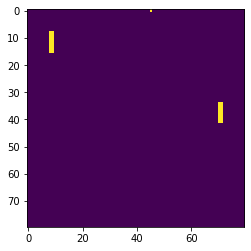

In [110]:
for i in range(200):
    env.render()
    action = np.random.randint(2) + 2
    obs, reward, done, _ = env.step(action)
    player_loc, opponent_loc, ball_y, ball_x, v_y, v_x = policy.generate_features(obs, prev_obs)
    print('Player loc:', player_loc)
    print('Opponent_loc:', opponent_loc)
    print('Ball y:', ball_y)
    print('Ball x:', ball_x)
    print('Velocity y:', v_y)
    print('Velocity x:', v_x)
    prev_obs = obs
    if i > 90:
        time.sleep(0.1)

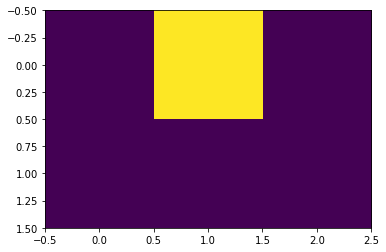

In [94]:
plt.imshow(policy.temp[0:2,44:47])

In [95]:
policy.temp[0:3,44:47]

array([[0, 1, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=uint8)

In [96]:
np.where(policy.temp[0:3,44:47]== 1.)

(array([0], dtype=int64), array([1], dtype=int64))

In [104]:
np.where(policy.temp == 1.)

(array([0], dtype=int64), array([45], dtype=int64))

In [86]:
env.close()

In [105]:
policy.get_ball(policy.temp)

(array([0], dtype=int64), array([45], dtype=int64))


(array([0], dtype=int64), array([45], dtype=int64))

In [41]:
prev_obs

0

In [35]:
a = env.reset()

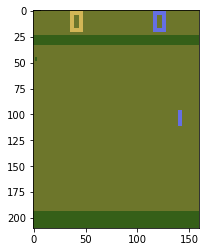

In [37]:
plt.imshow(a)

In [103]:
env.close()